In [43]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.ln = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        out = self.ln(x)
        out = self.fc(out)
        out = self.gelu(out)
        out = self.dropout(out)
        return x + out
    
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_blocks, dropout=0.1):
        super().__init__()
        
        self.init_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        x = self.init_layer(x)
        for block in self.blocks:
            x = block(x)
        
        x = self.output_layer(x)
        return self.softplus(x).flatten()
    
    @staticmethod
    def criterion(pred, y):
        eps = 1e-9
        return torch.sqrt(torch.mean(torch.square((y - pred) / (y + eps))))

In [45]:
df = pd.read_csv('../baseline2.csv', index_col=False).iloc[:, 1:]
df.shape

(428910, 9)

In [46]:
df['log_size'] = np.log(df['size'])
df['target'] = df['target'] * 1000
df['sigma'] = df['sigma'] * 1000
df.head()

,stock_id,time_id,sigma,target,size,spread,time_diff,log_time_diff,timefunc,log_size
0,0,5,4.499364,4.135767,3179,7.922559,15,2.708050,0.310975,8.064322
1,0,11,1.204431,1.444587,1287,4.118409,23,3.135494,0.723982,7.160069
2,0,16,2.368527,2.168189,2161,6.476585,35,3.555348,0.971598,7.678326
3,0,31,2.573832,2.195261,1962,7.627233,28,3.332205,0.849035,7.581720
4,0,62,1.894499,1.747216,1791,4.302926,25,3.218876,0.779443,7.490529


In [47]:
X = df.loc[:, ['sigma', 'spread', 'log_size', 'timefunc', 'log_time_diff']]
y = df['target']

X = X.to_numpy()
y = y.to_numpy()

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, shuffle=True, random_state=1)

In [49]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, pin_memory=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=2048, pin_memory=True)

In [50]:
INPUT_DIM = X_train.shape[1]
NUM_BLOCKS = 2
HIDDEN_DIM = 64
DROPOUT_RATE = 0.05

model = MLP(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT_RATE
)

In [51]:
from torch.optim import AdamW
import torch.optim as optim

lr = 1e-3
weight_decay = 1e-5
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',       
    factor=0.5,
    patience=5,   
    threshold=1e-4,  
    verbose=True 
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 100
criterion = MLP.criterion
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(dataloader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss}")
    
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr < 1e-7:
        print("Early stopping: LR zbyt niski.")
        break

C:\Users\Witek\anaconda3\envs\mpsi\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.3171433270783038 | Val Loss: 0.26760555239948064
Epoch 2/100 | Train Loss: 0.26519409124110194 | Val Loss: 0.2647660485393292
Epoch 3/100 | Train Loss: 0.26421159787757975 | Val Loss: 0.27136948342258865
Epoch 4/100 | Train Loss: 0.2636845671647304 | Val Loss: 0.26178986216719086
Epoch 5/100 | Train Loss: 0.2601846980082022 | Val Loss: 0.2605923126275475
Epoch 6/100 | Train Loss: 0.2593613915346764 | Val Loss: 0.259700050426496
Epoch 7/100 | Train Loss: 0.25832668933514 | Val Loss: 0.259632240678813
Epoch 8/100 | Train Loss: 0.25775821889574463 | Val Loss: 0.25801206339855454
Epoch 9/100 | Train Loss: 0.257001435031762 | Val Loss: 0.25788174307829625
Epoch 10/100 | Train Loss: 0.256048242385323 | Val Loss: 0.2579872173232001
Epoch 11/100 | Train Loss: 0.2568122492851438 | Val Loss: 0.2571697416337761
Epoch 12/100 | Train Loss: 0.2576669100168589 | Val Loss: 0.25700974766467066
Epoch 13/100 | Train Loss: 0.256483685930033 | Val Loss: 0.2572257671807263
Epoch 

KeyboardInterrupt: 

In [52]:
with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    preds = model(X_test)
    test_loss = MLP.criterion(preds, y_test)
    print(test_loss)

tensor(0.2532, device='cuda:0')


In [53]:
print(torch.stack([preds[:10], y_test[:10]], dim=-1))

tensor([[5.3792, 6.4482],
        [1.2907, 1.1320],
        [2.0897, 2.3137],
        [1.9845, 2.0117],
        [3.7300, 3.8451],
        [1.9132, 2.2417],
        [3.7401, 4.9348],
        [2.8716, 2.1956],
        [2.6543, 2.0312],
        [2.5446, 2.9482]], device='cuda:0')


In [54]:
X_test[:10, 0]

tensor([6.8210, 1.3042, 2.2839, 1.8756, 4.1706, 2.0808, 4.3551, 2.9594, 2.7977,
        2.8511], device='cuda:0')

In [55]:
relative_errors_model = (torch.abs(preds - y_test) / y_test).to('cpu').detach().numpy().copy()
relative_errors_baseline = (torch.abs(X_test[:, 0] - y_test) / y_test).to('cpu').detach().numpy().copy()

Text(0.5, 1.0, 'Baseline relative errors (0.23210644721984863 on avg)')

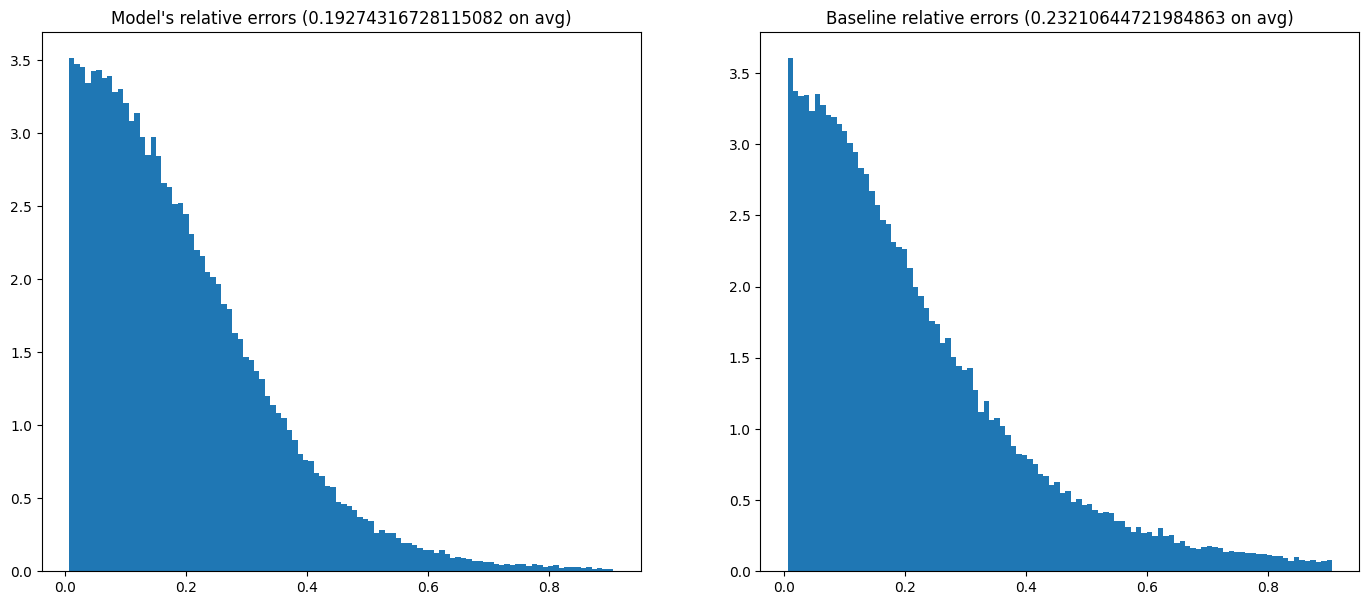

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(17,7))
ax1, ax2 = ax
quant1 = np.quantile(relative_errors_baseline, 0.02)
quant2 = np.quantile(relative_errors_baseline, 0.98)
ax1.hist(relative_errors_model, bins=100, density=True, range=(quant1, quant2))
ax1.set_title(f"Model's relative errors ({relative_errors_model.mean()} on avg)")

ax2.hist(relative_errors_baseline, bins=100, density=True, range=(quant1, quant2))
ax2.set_title(f"Baseline relative errors ({relative_errors_baseline.mean()} on avg)")